In [43]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load your dataset
import os

# Relative path to the data file from utils folder
# data_file_path = os.path.join('..', 'data', 'cleaned_data_withextrainfo.csv')
# df= pd.read_csv(data_file_path)
df= pd.read_csv('../data/cleaned_data_withextrainfo.csv')
#df=df[df['property_type']=='HOUSE']
#df=df[df['property_type']=='APARTMENT']
df.shape

/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_74097/1000244985.py:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('../data/cleaned_data_withextrainfo.csv')


(16408, 35)

In [44]:
df.columns

Index(['house_index', 'bedrooms', 'bathrooms', 'toilets', 'property_type',
       'property_subtype', 'locality', 'postal_code', 'street', 'number',
       'box', 'apptFloor', 'totalfloorCount', 'latitude', 'longitude',
       'kitchen', 'facades', 'furnished', 'terrace', 'terraceSurface',
       'fireplace', 'fireplaceCount', 'garden', 'gardenSurface', 'pool',
       'landSurface', 'livingArea', 'buildingState', 'constructionYear',
       'cadastralIncome', 'price', 'nearest_transport', 'nearest_school',
       'nearest_supermarket', 'mobib_score'],
      dtype='object')

In [45]:
# df_featured=df[['locality','bedrooms', 'bathrooms','livingArea','cadastralIncome','buildingState','toilets','facades','pool','price']]
df_featured=df[['locality','mobib_score','bedrooms', 'bathrooms','cadastralIncome','livingArea','buildingState','constructionYear','facades','fireplace','toilets','pool','price']]
df_featured.shape

(16408, 13)

In [46]:


df_featured['bedrooms'] = df_featured['bedrooms'].fillna(df_featured['bedrooms'].mode())
df_featured['bathrooms'] = df_featured['bathrooms'].fillna(df_featured['bathrooms'].mode())
df_featured['toilets'] = df_featured['toilets'].fillna(df_featured['toilets'].mode())
df_featured['livingArea'] = df_featured['livingArea'].fillna(df_featured['livingArea'].mean())
df_featured['cadastralIncome'] = df_featured['cadastralIncome'].fillna(df_featured['cadastralIncome'].mean())
df_featured['facades'] = df_featured['facades'].fillna(2)
df_featured['pool'] = df_featured['pool'].fillna(0)
df_featured['fireplace'] = df_featured['fireplace'].fillna(1)

building_state_mapping = {
    'AS_NEW': 6,
    'JUST_RENOVATED': 5,
    'GOOD': 4,
    'TO_BE_DONE_UP': 3,
    'TO_RENOVATE':2,
    'TO_RESTORE':1
}
df_featured['buildingState'] = df_featured['buildingState'].map(building_state_mapping)
# Drop rows with NaN values
df_featured = df_featured.dropna()
df_featured = df_featured.dropna(subset=['price'])
#df_featured.isnull().sum()
df_featured.shape


/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_74097/408912534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_featured['bedrooms'] = df_featured['bedrooms'].fillna(df_featured['bedrooms'].mode())
/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_74097/408912534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_featured['bathrooms'] = df_featured['bathrooms'].fillna(df_featured['bathrooms'].mode())
/var/folders/db/gqzpbl8d1vxgl2x39wd0j1cw0000gp/T/ipykernel_74097/408912534.py

(12684, 13)

In [47]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_without_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    #print(f'{len(df)-len(df_without_outliers)} rows have been removed from the {column} column')
    return df_without_outliers


#handling the outliers
df_featured=remove_outliers(df_featured, 'price')
df_featured=remove_outliers(df_featured, 'livingArea')
df_featured=remove_outliers(df_featured, 'bathrooms')
df_featured=remove_outliers(df_featured, 'bedrooms')
df_featured=remove_outliers(df_featured, 'facades')
df_featured=remove_outliers(df_featured, 'toilets')
df_featured=remove_outliers(df_featured, 'pool')
df_featured=remove_outliers(df_featured,'cadastralIncome')


df_featured.shape
df_featured.isnull().sum()

locality            0
mobib_score         0
bedrooms            0
bathrooms           0
cadastralIncome     0
livingArea          0
buildingState       0
constructionYear    0
facades             0
fireplace           0
toilets             0
pool                0
price               0
dtype: int64

In [48]:
# Split the dataset

import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
import category_encoders as ce
import matplotlib.pyplot as plt
import pickle


train_data, test_data = train_test_split(df_featured, test_size=0.2, random_state=42)

# Fit TargetEncoder on the training set
encoder = ce.TargetEncoder(cols=['locality'],smoothing=5)
train_data['locality'] = encoder.fit_transform(train_data['locality'], train_data['price'])

test_data['locality'] = encoder.transform(test_data['locality'])
print(train_data['locality'])
# Save the encoder for future predictions
# with open('../pickles/target_encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# Separate features (X) and target (y) for the training and test sets
X_train = train_data.drop(columns=['price'])  # Drop the target column
y_train = train_data['price']                # Target variable

X_test = test_data.drop(columns=['price'])   # Drop the target column
y_test = test_data['price']     
original_feature_names=X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# with open('../pickles/scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

num=X_train.shape[1]
pca = PCA(n_components=num)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Save the PCA transformer
# with open('../pickles/pca.pkl', 'wb') as f:
#     pickle.dump(pca, f)
    
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

# Save the polynomial transformer for future predictions
# with open('../pickles/poly_transform.pkl', 'wb') as file:
#     pickle.dump(poly, file)

feature_names = poly.get_feature_names_out(original_feature_names)
   
model=ElasticNet(max_iter=10000, alpha=1.0, l1_ratio=1.0)
model.fit(X_train, y_train)
#y_train_pred = model.predict(X_test)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#mae_train = mean_absolute_error(X_train, y_train)
#print(f"Mean Absolute Error on training data : {mae}")
print(f"Mean Absolute Error on test data: {mae}")
print(f"Mean Squared Error: {mse}")
rmse = np.sqrt(mse)
print(f"rmse: {rmse}")
print(f"R² Score: {r2}")             # Target variable

# Verify the shapes
print(y_pred)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# with open('../pickles/price_model.pkl', 'wb') as file:
#     pickle.dump(model, file)

# new_property=[['Gent', 8.0, 2, 1, 1200, 84, 4, 1991, 2, 1, 1, 0]]
# new_data_poly = poly.transform(new_property)
# predict_price=model.predict(new_data_poly)
# print(f"Predicted Price for new property is : {predict_price[0]}")

792      416462.228388
14026    475985.512687
9211     429447.785407
12067    442792.911771
14690    998698.964602
             ...      
16184    415577.929094
6607     430314.535644
7209     406709.706950
957      475985.512687
9417     357182.210779
Name: locality, Length: 9631, dtype: float64
Mean Absolute Error on test data: 99972.10023833191
Mean Squared Error: 27614867874.05416
rmse: 166177.21827631537
R² Score: 0.6924323813473299
[ 330856.20467075  245315.57044343  514921.62818854 ...  480837.60242912
  442783.45329989 1153471.00009006]
X_train shape: (9631, 90)
y_train shape: (9631,)
X_test shape: (2408, 90)
y_test shape: (2408,)


/Users/Karthika/Desktop/becode/python/immoEliza_propertyPrice_predictor/predenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.355e+12, tolerance: 8.415e+10
  model = cd_fast.enet_coordinate_descent(


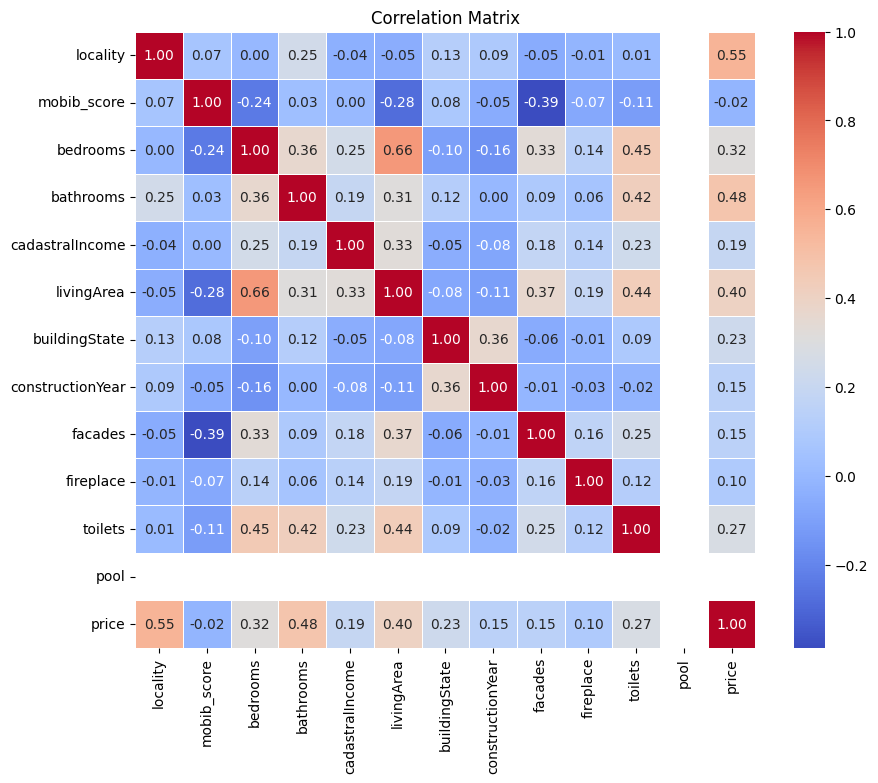

price               1.000000
locality            0.554733
bathrooms           0.476861
livingArea          0.401326
bedrooms            0.315892
toilets             0.274314
buildingState       0.227274
cadastralIncome     0.191139
facades             0.148701
constructionYear    0.147859
fireplace           0.100461
mobib_score        -0.017061
pool                     NaN
Name: price, dtype: float64


In [50]:
correlation_matrix = train_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig("../assets/images/Correlation_heatmap.png")
plt.show()
print(correlation_matrix['price'].sort_values(ascending=False))

In [23]:
with open('../pickles/target_encoder.pkl', 'rb') as f:
    target_encoder = pickle.load(f)

with open('../pickles/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the PCA transformer
with open('../pickles/pca.pkl', 'rb') as f:
    pca = pickle.load(f)
    
new_property=[['Knokke', 9.0, 2, 1, 1200, 84, 6, 2024, 2, 1, 2, 0]]
new_data_df = pd.DataFrame(new_property, 
                           columns=['locality','mobib_score','bedrooms', 'bathrooms','cadastralIncome','livingArea','buildingState','constructionYear','facades','fireplace','toilets','pool'])

# Apply the transformation to the 'locality' column
new_data_df['locality'] = target_encoder.transform(new_data_df['locality'])
new_data_scaled = scaler.transform(new_data_df)
new_data_pca = pca.transform(new_data_scaled)
new_data_poly = poly.transform(new_data_pca)
predict_price=model.predict(new_data_poly)
print(f"Predicted Price for new property is : {predict_price[0]}")

Predicted Price for new property is : 686208.9725840733


In [83]:
coefficients = model.coef_

#Create a DataFrame for ranking
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Display the ranking
print(coeff_df.head(20))

                        Feature   Coefficient    Importance
1                   mobib_score  90526.756067  90526.756067
10                      toilets  76244.994865  76244.994865
4               cadastralIncome  69345.434871  69345.434871
0                      locality  69297.585222  69297.585222
7              constructionYear  51528.605724  51528.605724
6                 buildingState -36031.848536  36031.848536
33          mobib_score toilets  29059.390182  29059.390182
8                       facades  27908.806478  27908.806478
46    bathrooms cadastralIncome -23490.074538  23490.074538
13         locality mobib_score  21890.880216  21890.880216
16     locality cadastralIncome  20890.112480  20890.112480
17          locality livingArea  18715.636800  18715.636800
60      cadastralIncome toilets  18426.315124  18426.315124
72      buildingState fireplace -18193.928524  18193.928524
9                     fireplace -17471.844139  17471.844139
64  livingArea constructionYear  17379.8

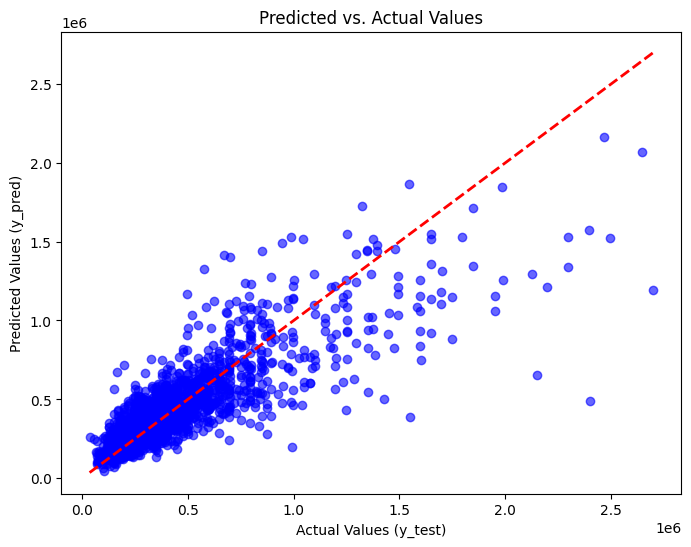

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)  # Perfect prediction line
plt.title("Predicted vs. Actual Values")
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.savefig("../assets/images/PredvsActual.png")
plt.show()


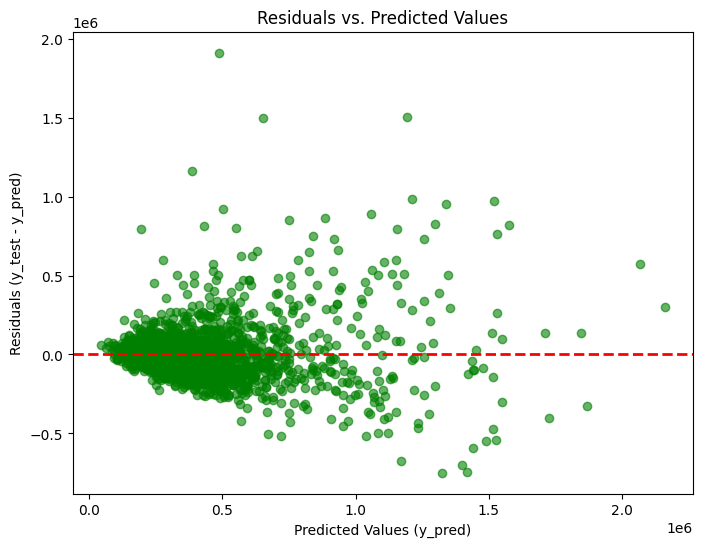

In [40]:
# Residual plot
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values (y_pred)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.savefig("../assets/images/ResidualvsPred.png")
plt.show()


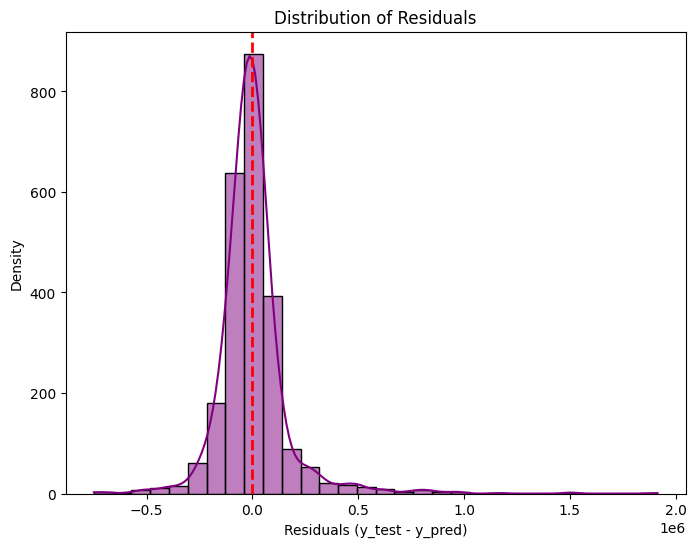

In [39]:
#Density Plot of Residuals
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (y_test - y_pred)")
plt.ylabel("Density")
plt.savefig("../assets/images/ResidualDensity.png")
plt.show()
